✅ Подключение к серверу Trino установлено.
📋 Список всех доступных каталогов в Trino:
   Catalog
   iceberg
     mysql
postgresql
    system

🔍 Проверка каталога 'postgresql':
Схемы в 'postgresql':
            Schema
information_schema
        pg_catalog
            public

📊 Таблицы в схеме 'postgresql.information_schema':
           Table
applicable_roles
         columns
   enabled_roles
           roles
        schemata
table_privileges
          tables
           views

🔍 Проверка каталога 'mysql':
Схемы в 'mysql':
            Schema
information_schema
performance_schema
          sales_db

📊 Таблицы в схеме 'mysql.information_schema':
           Table
applicable_roles
         columns
   enabled_roles
           roles
        schemata
table_privileges
          tables
           views
📈 Запрос 1: Анализ продаж по месяцам
Результат запроса 1:
sales_month  orders_count total_revenue avg_order_value
    2024-01             2        240.49          120.25
    2024-02             2   

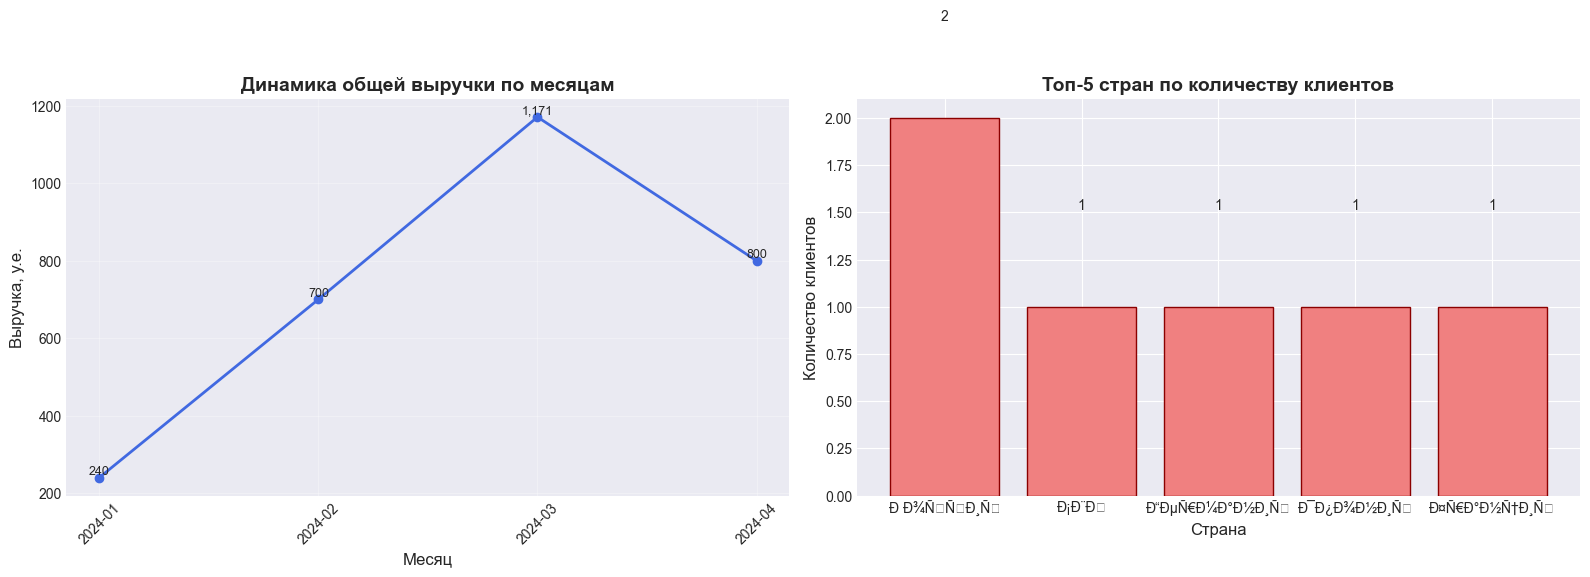

✅ Схема 'iceberg.final_project' создана или уже существует.
✅ Bucket 'warehouse' уже существует в MinIO
✅ Политика доступа настроена
✅ Iceberg таблица успешно создана!

🔍 Проверка созданной таблицы...
Созданные данные:
  sales_month  orders_count total_revenue avg_order_value
0     2024-01             2        240.49          120.25
1     2024-02             2        700.25          350.13
2     2024-03             5       1170.79          234.16
3     2024-04             4        799.95          199.99

📋 Метаданные таблицы:
Empty DataFrame
Columns: [table_name, column_name, data_type]
Index: []


True

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from trino import dbapi
import warnings
import boto3
from botocore.client import Config
import json

TRINO_HOST = "localhost"
TRINO_PORT = 8080
TRINO_USER = "admin"
TRINO_CATALOG = "system"

ICEBERG_CATALOG = "iceberg"
POSTGRES_CATALOG = "postgresql"
MYSQL_CATALOG = "mysql"
ICEBERG_CATALOG = "iceberg"
MY_SCHEMA = "final_project"

warnings.filterwarnings('ignore')

conn = dbapi.connect(
    host=TRINO_HOST,
    port=TRINO_PORT,
    user=TRINO_USER,
    catalog=TRINO_CATALOG,
)
print("✅ Подключение к серверу Trino установлено.")


def run_query(connection, query):
    cursor = connection.cursor()
    cursor.execute(query)

    if cursor.description is not None:
        columns = [desc[0] for desc in cursor.description]
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=columns)
        cursor.close()
        return df
    else:

        cursor.close()
        return None


print("📋 Список всех доступных каталогов в Trino:")
df_catalogs = run_query(conn, "SHOW CATALOGS")
print(df_catalogs.to_string(index=False))

print(f"\n🔍 Проверка каталога '{POSTGRES_CATALOG}':")
try:
    df_postgres_schemas = run_query(conn, f"SHOW SCHEMAS FROM {POSTGRES_CATALOG}")
    print(f"Схемы в '{POSTGRES_CATALOG}':")
    print(df_postgres_schemas.to_string(index=False))

    if not df_postgres_schemas.empty:
        sample_schema = df_postgres_schemas.iloc[0, 0]
        df_postgres_tables = run_query(conn, f"SHOW TABLES FROM {POSTGRES_CATALOG}.{sample_schema}")
        print(f"\n📊 Таблицы в схеме '{POSTGRES_CATALOG}.{sample_schema}':")
        print(df_postgres_tables.to_string(index=False))
    else:
        print(f"⚠️ В каталоге '{POSTGRES_CATALOG}' не найдено ни одной схемы.")
except Exception as e:
    print(f"❌ Ошибка при доступе к каталогу '{POSTGRES_CATALOG}': {e}. Проверьте настройки коннектора [citation:9].")

print(f"\n🔍 Проверка каталога '{MYSQL_CATALOG}':")
try:
    df_mysql_schemas = run_query(conn, f"SHOW SCHEMAS FROM {MYSQL_CATALOG}")
    print(f"Схемы в '{MYSQL_CATALOG}':")
    print(df_mysql_schemas.to_string(index=False))

    if not df_mysql_schemas.empty:
        sample_schema = df_mysql_schemas.iloc[0, 0]
        df_mysql_tables = run_query(conn, f"SHOW TABLES FROM {MYSQL_CATALOG}.{sample_schema}")
        print(f"\n📊 Таблицы в схеме '{MYSQL_CATALOG}.{sample_schema}':")
        print(df_mysql_tables.to_string(index=False))
    else:
        print(f"⚠️ В каталоге '{MYSQL_CATALOG}' не найдено ни одной схемы.")
except Exception as e:
    print(f"❌ Ошибка при доступе к каталогу '{MYSQL_CATALOG}': {e}. Проверьте настройки коннектора [citation:10].")

print("📈 Запрос 1: Анализ продаж по месяцам")
query_sales_by_month = """
                       SELECT DATE_FORMAT(order_date, '%Y-%m') AS sales_month,
                              COUNT(order_id)                  AS orders_count,
                              SUM(total_amount)                AS total_revenue,
                              AVG(total_amount)                AS avg_order_value
                       FROM postgresql.public.orders
                       WHERE status = 'completed'
                       GROUP BY DATE_FORMAT(order_date, '%Y-%m')
                       ORDER BY sales_month \
                       """
df_sales_monthly = run_query(conn, query_sales_by_month)
print("Результат запроса 1:")
print(df_sales_monthly.to_string(index=False))
print(f"Загружено строк: {len(df_sales_monthly)}")

print("\n🌍 Запрос 2: Географическое распределение клиентов")
query_top_countries = """
                      SELECT country,
                             COUNT(customer_id) AS customer_count
                      FROM mysql.sales_db.customers
                      GROUP BY country
                      ORDER BY customer_count DESC LIMIT 5 \
                      """
df_top_countries = run_query(conn, query_top_countries)
print("Результат запроса 2:")
print(df_top_countries.to_string(index=False))
print(f"Загружено строк: {len(df_top_countries)}")

print("\n🔄 Формирование финального агрегированного DataFrame...")

final_df = df_sales_monthly.copy()

print("Структура финального DataFrame:")
print(final_df.info())
print("\nПервые строки финального DataFrame:")
print(final_df.head())

plt.style.use('seaborn-v0_8-darkgrid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(df_sales_monthly['sales_month'], df_sales_monthly['total_revenue'], marker='o', linewidth=2, color='royalblue')
ax1.set_title('Динамика общей выручки по месяцам', fontsize=14, fontweight='bold')
ax1.set_xlabel('Месяц', fontsize=12)
ax1.set_ylabel('Выручка, у.е.', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

for i, v in enumerate(df_sales_monthly['total_revenue']):
    ax1.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

bars = ax2.bar(df_top_countries['country'], df_top_countries['customer_count'], color='lightcoral', edgecolor='darkred')
ax2.set_title('Топ-5 стран по количеству клиентов', fontsize=14, fontweight='bold')
ax2.set_xlabel('Страна', fontsize=12)
ax2.set_ylabel('Количество клиентов', fontsize=12)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
create_schema_query = f"CREATE SCHEMA IF NOT EXISTS {ICEBERG_CATALOG}.{MY_SCHEMA}"
try:
    run_query(conn, create_schema_query)
    print(f"✅ Схема '{ICEBERG_CATALOG}.{MY_SCHEMA}' создана или уже существует.")
except Exception as e:
    print(f"⚠️ Не удалось создать схему: {e}. Возможно, она уже существует.")

def setup_minio_bucket():
    try:
        s3_client = boto3.client(
            's3',
            endpoint_url='http://localhost:9000',
            aws_access_key_id='minioadmin',
            aws_secret_access_key='minioadmin123',
            config=Config(signature_version='s3v4'),
            region_name='us-east-1'
        )
        try:
            s3_client.head_bucket(Bucket='warehouse')
            print("✅ Bucket 'warehouse' уже существует в MinIO")
        except:

            s3_client.create_bucket(Bucket='warehouse')
            print("✅ Bucket 'warehouse' создан в MinIO")

        policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {"AWS": "*"},
                    "Action": ["s3:*"],
                    "Resource": ["arn:aws:s3:::warehouse/*"]
                }
            ]
        }

        s3_client.put_bucket_policy(
            Bucket='warehouse',
            Policy=json.dumps(policy)
        )
        print("✅ Политика доступа настроена")

    except Exception as e:
        print(f"⚠️ Ошибка настройки MinIO: {e}")
        print("Убедитесь, что MinIO запущен на localhost:9000")


def create_iceberg_table():
    ctas_query = f"""
    CREATE TABLE IF NOT EXISTS iceberg.final_project.aggregated_sales_summary AS
    SELECT
        DATE_FORMAT(order_date, '%Y-%m') AS sales_month,
        COUNT(order_id) AS orders_count,
        SUM(total_amount) AS total_revenue,
        AVG(total_amount) AS avg_order_value
    FROM postgresql.demo_db.public.orders
    WHERE status = 'completed'
    GROUP BY DATE_FORMAT(order_date, '%Y-%m')
    ORDER BY sales_month
    """

    try:
        run_query(conn, ctas_query)
        print("✅ Iceberg таблица успешно создана!")

        print("\n🔍 Проверка созданной таблицы...")
        result = run_query(conn, "SELECT * FROM iceberg.final_project.aggregated_sales_summary")
        print("Созданные данные:")
        print(result)

        print("\n📋 Метаданные таблицы:")
        metadata = run_query(conn, """
                                   SELECT table_name,
                                          column_name,
                                          data_type
                                   FROM system.information_schema.columns
                                   WHERE table_schema = 'final_project'
                                     AND table_catalog = 'iceberg'
                                   ORDER BY ordinal_position
                                   """)
        print(metadata)

        return True

    except Exception as e:
        print(f"❌ Ошибка создания таблицы: {e}")
        return False

setup_minio_bucket()
create_iceberg_table()
